In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck')
Vbox_source = np.prod(halocat.Lbox)

halocat2 = CachedHaloCatalog(simname='multidark')

from halotools.empirical_models import PrebuiltHodModelFactory
model = PrebuiltHodModelFactory('cacciato09', prim_haloprop_key='halo_mvir', threshold=10.5)

model.populate_mock(halocat)
#test comment line

In [9]:
from astropy.table import Table 

source_halos = Table(np.copy(model.mock.halo_table))
source_gals = Table(np.copy(model.mock.galaxy_table))
source_gals['host_centric_x'] = source_gals['x'] - source_gals['halo_x']
source_gals['host_centric_y'] = source_gals['y'] - source_gals['halo_y']
source_gals['host_centric_z'] = source_gals['z'] - source_gals['halo_z']

# low, high = 0, 250
# source_halos_mask = (source_halos['halo_x'] >= low) & (source_halos['halo_x'] < high)
# source_halos_mask *= (source_halos['halo_y'] >= low) & (source_halos['halo_y'] < high)
# source_halos_mask *= (source_halos['halo_z'] >= low) & (source_halos['halo_z'] < high)
# source_halos = source_halos[source_halos_mask]

# source_gals_mask = (all_source_gals['halo_x'] >= low) & (all_source_gals['halo_x'] < high)
# source_gals_mask *= (all_source_gals['halo_y'] >= low) & (all_source_gals['halo_y'] < high)
# source_gals_mask *= (all_source_gals['halo_z'] >= low) & (all_source_gals['halo_z'] < high)
# source_gals = all_source_gals[source_gals_mask]

from halotools.utils import crossmatch
idxA, idxB = crossmatch(source_gals['halo_hostid'], source_halos['halo_id'])
assert len(source_gals) == len(source_gals[idxA])

In [12]:
model2 = PrebuiltHodModelFactory('cacciato09', prim_haloprop_key='halo_mvir', threshold=10.5)

model2.populate_mock(halocat2)
target_halos = Table(model2.mock.halo_table)
all_source_gals = Table(model2.mock.galaxy_table)

In [13]:
from galsampler import halo_bin_indices

mhost_min = target_halos['halo_mvir'].min()
mhost_max = target_halos['halo_mvir'].max()
log_mhost_min, log_mhost_max = np.log10(mhost_min), np.log10(mhost_max)
mhost_bins = np.logspace(log_mhost_min, 14.75, 30)

source_halos['bin_number'] = halo_bin_indices(mass=(source_halos['halo_mvir'], mhost_bins))
target_halos['bin_number'] = halo_bin_indices(mass=(target_halos['halo_mvir'], mhost_bins))

In [14]:
from galsampler import source_galaxy_selection_indices

source_galaxies_host_halo_id = source_gals['halo_hostid']
source_halos_bin_number = source_halos['bin_number']
source_halos_halo_id = source_halos['halo_id']
target_halos_bin_number = target_halos['bin_number']
target_halo_ids = target_halos['halo_id']
nhalo_min = 1
bins = mhost_bins

results = source_galaxy_selection_indices(source_galaxies_host_halo_id, 
                        source_halos_bin_number, source_halos_halo_id, 
                        target_halos_bin_number, target_halo_ids, 
                        nhalo_min, bins)
selection_indices, target_galaxy_target_halo_ids, target_galaxy_source_halo_ids = results

from halotools.utils import crossmatch
target_gals = Table()
target_gals['target_halo_id'] = target_galaxy_target_halo_ids
target_gals['source_halo_id'] = target_galaxy_source_halo_ids

keys_to_inherit_from_source = ('host_centric_x', 'host_centric_y', 
                               'host_centric_z', 'luminosity', 'gal_type')
for key in keys_to_inherit_from_source:
    target_gals[key] = source_gals[key][selection_indices]
    
keys_to_inherit_from_target = ('halo_x', 'halo_y', 'halo_z', 'halo_mvir') 
idxA, idxB = crossmatch(target_gals['target_halo_id'], target_halos['halo_id'])
for key in keys_to_inherit_from_target:
    target_gals[key] = 0.
    target_gals[key][idxA] = target_halos[key][idxB]

target_gals['x'] = target_gals['halo_x'] + target_gals['host_centric_x']
target_gals['y'] = target_gals['halo_y'] + target_gals['host_centric_y']
target_gals['z'] = target_gals['halo_z'] + target_gals['host_centric_z']

from halotools.empirical_models import enforce_periodicity_of_box
target_gals['x'] = enforce_periodicity_of_box(target_gals['x'], 1000.)
target_gals['y'] = enforce_periodicity_of_box(target_gals['y'], 1000.)
target_gals['z'] = enforce_periodicity_of_box(target_gals['z'], 1000.)

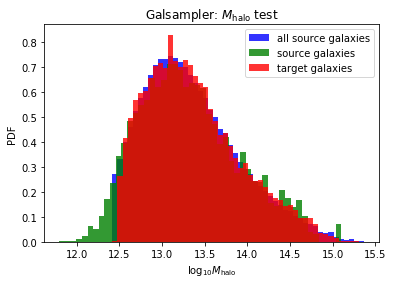

In [15]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(all_source_gals['halo_mvir']), bins=50, normed=True, alpha=0.8, 
          color='blue', label='all source galaxies')
__=ax.hist(np.log10(source_gals['halo_mvir']), bins=50, normed=True, alpha=0.8, 
          color='green', label='source galaxies')
__=ax.hist(np.log10(target_gals['halo_mvir']), bins=50, normed=True, alpha=0.8, 
          color='red', label='target galaxies')
xlabel = ax.set_xlabel(r'$\log_{10}M_{\rm halo}$')
ylabel = ax.set_ylabel(r'PDF')
title = ax.set_title(r'Galsampler: $M_{\rm halo}$ test')
legend = ax.legend()
figname = 'galsampler_Mhost_test.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


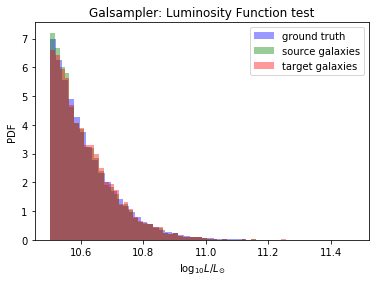

In [16]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(all_source_gals['luminosity']), bins=50, normed=True, alpha=0.4, 
          color='blue', label='ground truth')
__=ax.hist(np.log10(source_gals['luminosity']), bins=50, normed=True, alpha=0.4, 
          color='green', label='source galaxies')
__=ax.hist(np.log10(target_gals['luminosity']), bins=50, normed=True, alpha=0.4, 
          color='red', label='target galaxies')
xlabel = ax.set_xlabel(r'$\log_{10}L/L_{\odot}$')
ylabel = ax.set_ylabel(r'PDF')
title = ax.set_title(r'Galsampler: Luminosity Function test')
legend = ax.legend()
figname = 'galsampler_LF_test.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


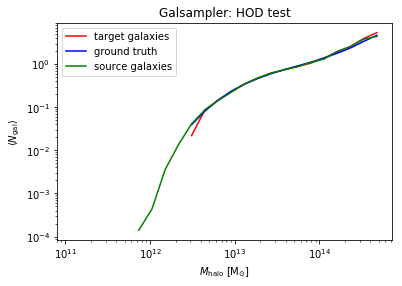

In [17]:
from halotools.mock_observables import hod_from_mock
hod_mass_bins = np.logspace(11, 14.75, 25)
hod_mass_mids = 0.5*(hod_mass_bins[:-1] + hod_mass_bins[1:])

target_hod, __ = hod_from_mock(target_gals['halo_mvir'], 
                           target_halos['halo_mvir'], haloprop_bins=hod_mass_bins)
true_hod, __ = hod_from_mock(all_source_gals['halo_mvir'], 
                           target_halos['halo_mvir'], haloprop_bins=hod_mass_bins)
source_hod, __ = hod_from_mock(source_gals['halo_mvir'], 
                           source_halos['halo_mvir'], haloprop_bins=hod_mass_bins)

fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.plot(hod_mass_mids, target_hod, color='red', label='target galaxies')
__=ax.plot(hod_mass_mids, true_hod, color='blue', label='ground truth')
__=ax.plot(hod_mass_mids, source_hod, color='green', label='source galaxies')

legend = ax.legend()
xlabel = ax.set_xlabel(r'$M_{\rm halo}$ $[{\rm M_{\odot}}]$')
ylabel = ax.set_ylabel(r'$\langle N_{\rm gal}\rangle$')
title = ax.set_title(r'Galsampler: HOD test')
figname = 'galsampler_HOD_test.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


In [19]:
from halotools.mock_observables import return_xyz_formatted_array, tpcf

target_gals_pos = return_xyz_formatted_array(target_gals['x'], 
                                             target_gals['y'], target_gals['z'])
source_gals_pos = return_xyz_formatted_array(source_gals['x'], 
                                             source_gals['y'], source_gals['z'])
all_source_gals_pos = return_xyz_formatted_array(all_source_gals['x'], 
                                             all_source_gals['y'], all_source_gals['z'])

rbins = np.logspace(-1, 1.25, 25)

xi_target_gals = tpcf(target_gals_pos, rbins, period=1000)

xi_source_gals = tpcf(source_gals_pos, rbins, period=250)

xi_all_source_gals = tpcf(all_source_gals_pos, rbins, period=1000)

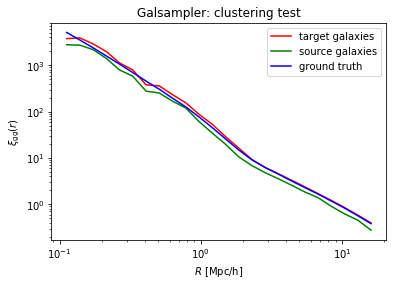

In [20]:
fig, ax = plt.subplots(1, 1)

rmids = 0.5*(rbins[:-1] + rbins[1:])
__=ax.loglog()

__=ax.plot(rmids, xi_target_gals, label='target galaxies', color='red')
__=ax.plot(rmids, xi_source_gals, label='source galaxies', color='green')
__=ax.plot(rmids, xi_all_source_gals, label='ground truth', color='blue')

legend = ax.legend()
xlabel = ax.set_xlabel(r'$R$ $[{\rm Mpc/h}]$')
ylabel = ax.set_ylabel(r'$\xi_{\rm gg}(r)$')
title = ax.set_title(r'Galsampler: clustering test')
figname = 'galsampler_clustering_test.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')
